
# Homework 4 | Neural implicits: using a simple MLP to encode 3D geometry
4.453x Creative Machine Learning for Design<br/>
*Renaud Danhaive, Ous Abou Ras, Natasha Hirt, Caitlin Mueller*
<br/><br/>


---

In this assignment, you will learn to represent a 3D geometry with a so-called *neural implicit*. We'll explain what a neural implicit is briefly here, but if you're interested in this topic, there's a good deal of literature out there. A good starting point to learn more about neural implicits is the [2020 paper by Davies, Nowrouzezahrai, and Jacobson](https://arxiv.org/abs/2009.09808).

So, what is a neural implicit? To answer this, let's first consider some of the different way a shape can be represented computationally. There are of course the obvious suspects: meshes, point-clouds, NURBS, voxels, etc. However, there is another powerful way to represent 3D geometry: functions that define whether or not any point in the 3D space is inside or outside of the geometry described. For example, say a function $S(\mathbf{x})$ is an implicit representation of our geometry; we can then query it at a point $\mathbf{x_1}$. If $S(\mathbf{x_1})$ is a negative value, the point is inside the geometry, and if it is positive, the point is outside of it. $S(\mathbf{x})=0$ defines the outer surface of the solid.

One type of function that takes this form is *signed distance functions (SDF)*, i.e. they return at any point the distance to the outer surface of the geometry with the sign indicating whether the point is inside or outside. Some geometries are really simple to represent with SDFs. For example, the SDF of a sphere with radius $r$ and centered around zero is $x^2+y^2+z^2-r^2$. Devising SDFs for simple shapes is fairly simple, and more complex shapes can obtained through boolean operations, which amount to arithmetic operations for SDFs.

Nevertheless, it is difficult to express arbitrary geometries with a SDF. You could quickly end up having to define a function with thousand of terms and factors. Wait, but what is a neural network if not a function with thousands (or millions or more) of parameters? That's it, the main idea behind neural implicits: let's represent the SDF by a neural network. To figure out the weights of the neural network that actually represent the shape at hand, we can simply sample points in the 3D space (more or less intelligently), compute their distance to the shape, and train a neural network (for example an MLP) to predict distance based on location. After convergence, we've got ourselves a SDF.

In order, we will:
1. Load a shape and visualize it.
2. Sample points around the shape and compute their distances to the shape to build a dataset.
3. Build an MLP and train on the dataset.
4. Sample the MLP at different resolutions and visualize the resulting shapes with the marching cubes algorithm.
5. Compose the MLP with another function and visualize the results.

🎁 To complete this assignment, we invite you to refer the two other notebooks we covered in class:
- [Notebook 1: MLP trained on on a toy dataset](https://drive.google.com/file/d/14SaVOIGZA9sQPp8hiEcKBKN_EoCw3iij/view?usp=share_link)
- [Notebook 2: Image generation with a CPPN](https://drive.google.com/file/d/1zCC18VMxRsvUuONsgdv2s0NFQi0u1A6Y/view?usp=sharing)
- [Notebook 3: MLP trained on MNIST](https://drive.google.com/file/d/1ucRItpmHr1dBgqYex4LSyFTT2PPGCrxD/view?usp=share_link)


❗❗❗ The deliverable for this homework is a link to your completed and runnable notebook (please share it in *commenter* mode).

❗❗❗ Make sure to use a GPU runtime for this assignment.

## **0.0 | Setup** 🚧


### 0.1 | Installing Conda and other libraries **NEED to RESTART** 
We need `igl` in this notebook, meaning we need to install conda. Run the first 2 cells and wait until conda is installed and the runtime has restarted before you run the subsequent cells.

In [ ]:
!pip install trimesh pyDOE PyMCubes &> /dev/null

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!pip install -q condacolab &> /dev/null 
import condacolab
condacolab.install_from_url("https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh")

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c conda-forge igl &> /dev/null  

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!pip install -U kaleido

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


RESTART AGAIN after the second installs

### 0.2 | Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets as widgets
import trimesh
import igl
import pyDOE as doe
from tqdm.notebook import tqdm
import mcubes
import plotly.io as pio
import plotly.graph_objects as go

In [ ]:
# @markdown ### 0.3 | Styling

import google
is_dark = google.colab.output.eval_js(
    'document.documentElement.matches("[theme=dark]")'
)

matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams["hatch.color"] = "white"

if is_dark:
    # load style sheet for matplotlib, a plotting library we use for 2D visualizations
    plt.style.use(
        "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
    )
    plt.style.use("dark_background")
    plt.rcParams.update(
        {
            "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
            "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
            "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
            "grid.color": (0.4, 0.4, 0.4, 1.0),
        }
    )

    plotly_template = pio.templates["plotly_dark"]
    pio.templates["draft"] = go.layout.Template(
        layout=dict(
            plot_bgcolor="rgba(56,56,56,0)",
            paper_bgcolor="rgba(56,56,56,0)",
        )
    )
    pio.templates.default = "plotly_dark+draft"
else:
    plt.style.use(
        "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
    )

## **1.0 | Load a shape and visualize it** 😵

### 1.1 | Download and load the shape
We will load a freely downloadable 3D scan of a coral by the Rhode Island School of Design (RISD) Nature Lab. The original scan includes geometry (i.e. mesh) and texture (i.e. image), but we'll only work with the geometry.

"Coral" (https://skfb.ly/6YX6J) by RISD Nature Lab is licensed under [Creative Commons Attribution](http://creativecommons.org/licenses/by/4.0/).

In [ ]:
%%bash
curl -o coral.obj https://raw.githubusercontent.com/danhaive/4.453x-resources/master/05/data/52.19_coral.obj &> /dev/null

bash: /usr/local/lib/libtinfo.so.6: no version information available (required by bash)


In [ ]:
coral = trimesh.load_mesh("coral.obj", skip_materials=True)

The warning tells us the texture file is missing, but it won't be a problem because we'll only care about the geometry.

### 1.2 ❓ Visualize the loaded mesh (`coral`) using plotly [1.0]

Let's define a helper function to plot a mesh using plotly. No need to reinvent the wheel here: feel free to copy-paste from a previous notebook. Just make sure to specify `flatshading` as `False` in the visualization. If you don't, you will barely be able to distinguish the shape.

Because the visualization function is used further in this notebook, please make sure to use the function signature specified.

In [ ]:
def visualize_mesh(vertices: np.ndarray, faces: np.ndarray, flatshading: bool = False, height=600, width=600, color="pink"):
  x, y, z = vertices.T
  i, j, k = faces.T
  fig = go.Figure(
      [
          go.Mesh3d(
              x=x,
              y=y,
              z=z,
              i=i,
              j=j,
              k=k,
              color=color,
          ),       
      ]
  )

  # styling
  fig.update_traces(
      flatshading=flatshading, lighting=dict(specular=1.0), showlegend=None, selector=dict(type="mesh3d")
  )
  fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    )
)
  fig.update_layout(margin=dict(r=5, l=5, b=5, t=5),height=600, width=600)
  fig.update_layout(scene_aspectmode="data")

  return fig

In [ ]:
# defining plotly renderer
pio.renderers.default = "png"

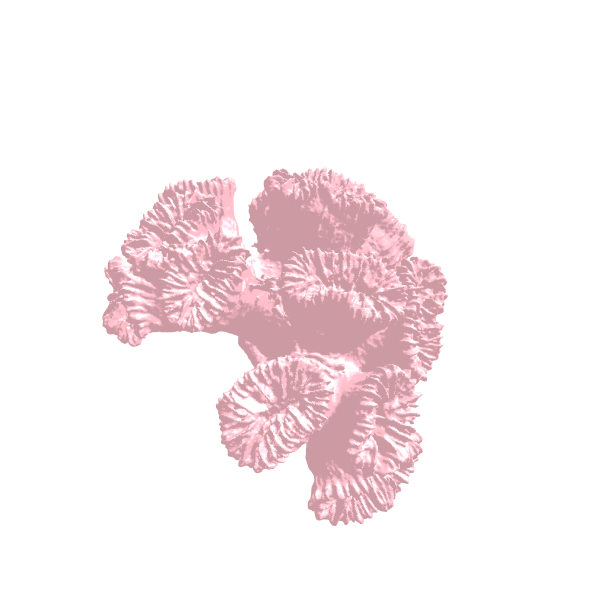

In [ ]:
mesh_visualization = visualize_mesh(coral.vertices, coral.faces, flatshading=False, width=800, height=800)
mesh_visualization

## **2.0 | Sampling Points** 🎯
Now, let's sample points around the shape. We'll sample many, many, many points because our shape is actually quite complex. Fortunately, the function to sample (signed distance) is quite cheap.

### 2.1 | Additional sampling functions

We've sampled spaces indiscriminately/uniformly until now, but here we want to oversample regions close the shape because that's where we want our model to be precise. We don't really care about encoding the SDF well far away from the shape, but we certainly do close to it.

Here, we'll take the approach proposed by [Davies, Nowrouzezahrai, and Jacobson](https://arxiv.org/abs/2009.09808): we'll densely sample the space using Latin Hypercube Sampling and use a probabilistic sample acceptance criterion based on the distance of the sample with respect to the mesh. We provide the sample acceptance/rejection logic in the cell below. Please refer to Section 2.1.2 of the paper to understand it.

In [ ]:
def accept_sample(distance, beta=5):
    acceptance_probability = np.exp(
        -beta * np.abs(distance)
    )  # the closer the point, the likelier it is to be accepted
    return np.random.binomial(1, acceptance_probability).astype(
        bool
    )  # this is a biased coin toss to figure out whether to accept the sample or not

We want to sample points in the space around the mesh, so we'll only sample inside the bounding box of the geometry.

In [ ]:
def get_buffered_bbox(mesh, bbox_relative_buffer=0.05):
    bbox = np.array([[np.min(coords), np.max(coords)] for coords in mesh.vertices.T])
    bbox_extent = bbox[:, 1] - bbox[:, 0]
    buffer = bbox_extent * bbox_relative_buffer
    bbox[:, 0] -= buffer
    bbox[:, 1] += buffer
    return bbox

### 2.2 ❓ Code a function `get_sdf_samples`that samples the signed distance function of a mesh [3.0]
We provide the signature of the function below along with hints of the steps you may to want to follow to obtain the desired results. 
The arguments of the function `n_samples`, `mesh`, `bbox`, and `beta` respectively refer to:
- `n_samples` > the number of samples to compute using LHS,
- `mesh` > the mesh (of type `Trimesh`) of the geometry to sample,
- `bbox` > the bounding box of the geometry,
- `beta` > a parameter that controls how stringent our acceptance criterion is.


The function should return a tuple of 2 arrays. The first one should contain the coordinates of the samples and the second should contain the distances from those points to the mesh surface.

In [ ]:
def get_sdf_samples(n_samples, mesh, bbox, beta=5):
    # 1. get samples in unit cube
    unit_samples = np.random.rand(n_samples, 3)
    # 2. scale unit cube samples to bbox
    bbox_min, bbox_max = bbox[:, 0], bbox[:, 1]
    samples = bbox_min + (bbox_max - bbox_min) * unit_samples
    # 3. compute distances to mesh using igl.signed_distance
    dist, _, _ =igl.signed_distance(samples, mesh.vertices, mesh.faces)
    # 4. normalize distances to allow for consistent filtering irrespectively of object scale
    max_abs_dist = np.max(np.abs(dist))
    dist /= max_abs_dist
    print(max(dist))
    print(min(dist))
    # 5. get a boolean mask of which samples to accept using accept_sample
    mask = accept_sample(dist, beta)
    # 6. return a tuple of with the coordinates and distances of the accepted samples
    return (samples[mask], dist[mask])

### 2.3 | Let's use `get_sdf_samples` to actually sample the shape.

In [ ]:
buffered_bbox = get_buffered_bbox(coral)
train_samples, train_distances = get_sdf_samples(
    100000, coral, buffered_bbox, beta=10
)

1.0
-0.2421867073271362


### 2.4 | Let's see how many samples were accepted.

In [ ]:
print(f"{train_samples.shape[0]} training samples were obtained.")

26818 training samples were obtained.


###2.5 ❓ Visualize the sampled points using plotly [1.5]
Plot the samples as a scatter plot of points in 3D. Each sample should be colored according to its distance to the mesh. Use a slider to interactively filter the samples shown based on how close they are to the surface.

It does not matter whether the interactivity is provided through a colab slider (already added to the cell) or an `ipywidgets` widget.

In [ ]:
from plotly.subplots import make_subplots
#@title  { run: "auto" }
distance_visibility_threshold = 0.21 #@param {type:"slider", min:0.01, max:1, step:0.05}
fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scene"}]])
mask = train_distances <= distance_visibility_threshold

filtered_samples = train_samples[mask]
filtered_distances = train_distances[mask]

x = filtered_samples[:, 0]
y = filtered_samples[:, 1]
z = filtered_samples[:, 2]

scatter_plot = go.Scatter3d(
        x=x, 
        y=y, 
        z=z, 
        mode='markers', 
        marker=dict(color=filtered_distances, 
                    colorscale='Plasma',
                    size=3, 
                    colorbar=dict(title="Distance"))
        )

fig.add_trace(scatter_plot, row=1, col=1)

fig.update_layout(margin=dict(r=5, l=5, b=5, t=5),height=700,)

In [ ]:
pio.renderers.default = "colab"

## **3.0 | Build and train neural network**

The task that the neural network needs to solve is simple: predict distance based on location. In addition, we have the luxury of synthesizing our own data, meaning we can generate as much as we need. For both of these reasons, we do not need to leverage a fancy neural network architecture, and we can reuse our good old Multi-Layer Perceptron.

### 3.1 ❓ Build a `RegressionMLP` class that implements a simple Multi-Layer Perceptron [2.0]
Define the layers of the network in the `__init__` method (make sure to use the arguments in the signature of the function) and implement the `forward` method. 

In [ ]:
class RegressionMLP(nn.Module):
    def __init__(
        self, n_hidden_layers=1, n_hidden_neurons=16, input_dim=3, output_dim=1, activation_function=nn.Tanh()
    ):
        super(RegressionMLP, self).__init__()
        self.layer_in = nn.Sequential(nn.Linear(input_dim, n_hidden_neurons), activation_function)
        hidden_layers = []
        for i in range(n_hidden_layers):
            hidden_layers.append(nn.Linear(n_hidden_neurons, n_hidden_neurons))
            hidden_layers.append(activation_function)
        self.layers_mid = nn.Sequential(*hidden_layers)
        self.layer_out = nn.Sequential(nn.Linear(n_hidden_neurons, output_dim))

    def forward(self, x):
        x = self.layer_in(x)
        x = self.layers_mid(x)
        x = self.layer_out(x)


        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.2 ❓ Create a neural network `neural_implict` and cast it to the device in use (you sould be using a GPU-enabled runtime) [0.5]
Let's create our neural network and cast it to the device in use (ideally, the GPU). Remember to change the values of input and output dim to fit your problem, and you should also probably try different n_hidden_neurons and n_hidden_layers values to get good results.

In [ ]:
neural_implicit = RegressionMLP().to(device)
print(neural_implicit)

RegressionMLP(
  (layer_in): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): Tanh()
  )
  (layers_mid): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Tanh()
  )
  (layer_out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)


Now comes the fun bit: training! To facilitate things, we'll use a `Dataloader` which will chunk our dataset in batches and shuffle it every time it has iterated over all the data (i.e. an epoch).

### 3.3 ❓ Define an Adam optimizer operating over the weights of the neural network [0.5]
Use a learning rate of `0.0001`.

In [ ]:
optimizer = torch.optim.Adam(neural_implicit.parameters(), lr=1e-4)

### 3.4 ❓ Define a training dataloader [1.0]
We will use this dataloader to iterate through the dataset in batches and shuffle the dataset at the end of each epoch.
Because our input and output dimensions are very small, we can use a large `batch_size`.

Note that we do not use a validation dataset here. Why? Because in this case, we are explictly trying to overfit our network to our samples. Again, please refer to Section 1 of the paper of [Davies, Nowrouzezahrai, and Jacobson](https://arxiv.org/abs/2009.09808) for why that is.

In [ ]:
print(train_samples.shape)
print(train_distances.shape)

(26888, 3)
(26888,)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 5000

# Concatenate the samples and distances into a single tensor
train_data = np.concatenate([train_samples, train_distances.reshape(-1, 1)], axis=1)
# Create a TensorDataset from the concatenated tensor
train_dataset = TensorDataset(torch.tensor(train_data,dtype=torch.float32))
# train_dataset = torch.tensor(train_data)
# Create a DataLoader with a specified batch size
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print(train_data.shape)

(26747, 4)


### 3.5 ❓ Train the neural network [3.5]
Use the dataloader and optimizer to train the neural network over `n_epochs`. Keep track of the loss function as training progresses. We provide a skeleton of the logic necessary to train the network. Please complete the implementation. We provide some steps to guide you, but you can ignore them if you feel confident about your solution.

Note: Please use the L1 loss as the loss function to optimize. The L1 loss is the name of the mean absolute error (MAE) in PyTorch. So far, we have used the L2 loss (mean squared error or MSE). The MSE is a useful loss function but it penalizes larger discrepancies more.  In contrast, in this problem, we care more about those points close to the mesh (small values) than the ones far away from the mesh. Therefore, we use the L1 loss.

In [ ]:
n_epochs = 250 # number of epochs
training_losses = [] # list to keep track of training loss

for i in tqdm(range(n_epochs)):
    for sample in tqdm(training_dataloader):
      # 1. reset optimizer gradient
      optimizer.zero_grad()
      # 2. get input features (coordinates) and targets (distances)
      coords = sample[0][:, :3]  
      targets = sample[0][:, 3:].squeeze(1)
      coords = coords.to(device)
      targets = targets.to(device)
      # 3. predict distances using neural network
      predicted = neural_implicit(coords)
      # 4. compute L1 Loss (hint: use nn.L1Loss())
      batch_loss = nn.L1Loss()(predicted, targets)
      # 5. backprop
      batch_loss.backward()
      # 6. gradient descent step
      optimizer.step()
      # 7. add loss value to list of training losses
      training_losses.append(batch_loss.item())


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:101: UserWarning:

Using a target size (torch.Size([1747])) that is different to the input size (torch.Size([1747, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

### 3.6 ❓ Plot the evolution of the training loss. Did the training appear successful? [1.0]
For the written portion, answer in a text cell below.

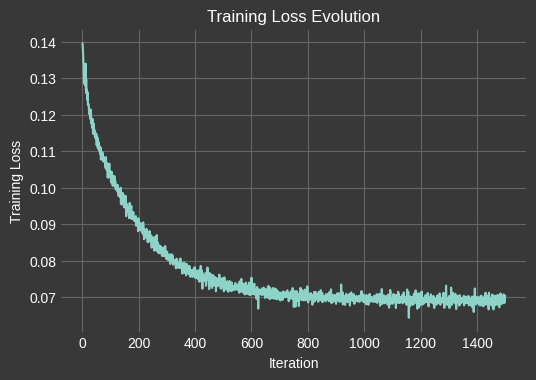

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

# Set axis labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Training Loss')

# Calculate total number of iterations
total_iterations = len(training_losses)

# Plot the training loss
ax.plot(range(1, total_iterations + 1), training_losses)

# Add a title
ax.set_title('Training Loss Evolution')

# Display the plot
plt.show()

*OBSERVATION: After training multiple times with different numbers of hidden layers and numbers of neurons, it appears that the trainning loss gets quite low after the first 50 epochs and it remains at that level. But the training seems successful because the training loss is low, as shown in the graph close to 0.07. I also found out that even with the same neural network, the training result can be really different.*

## **4.0 | Visualize the SDF encoded by the neural network using the marching cubes algorithm**
If you've successfully trained the network/neural implicit, it encodes the SDF well enough that you can regenerate the original geometry with an arbitrary resolution.

*No questions here: we just want to demsonstrate how a mesh can be recovered by generating a field of distance values and using the marching cubes algorithm to extract a mesh from it.*

By the way, you have used marching cubes before in this class, albeit in 2D. This is the underlying algorithm used by skimage when we plotted the constraint boundary in homework 2. ⏲

In [ ]:
resolution = 50

grid = np.array(
    [
        [x, y, z]
        for x in np.linspace(0, 1, resolution)
        for y in np.linspace(0, 1, resolution)
        for z in np.linspace(0, 1, resolution)
    ]
)

In [ ]:
sdf = neural_implicit.to("cpu")(torch.Tensor(grid))
sdf = sdf.detach().cpu().numpy().reshape((resolution, resolution, resolution))

In [ ]:
print("SDF min value:", sdf.min())
print("SDF max value:", sdf.max())
print("SDF mean value:", sdf.mean())

SDF min value: -0.00829415
SDF max value: 0.017813642
SDF mean value: 0.000535193


In [ ]:
sdf_mesh = mcubes.marching_cubes(sdf, 0)

In [ ]:
sdf_mesh[0].shape

(5142, 3)

We've got our mesh. Let's visualize it and see how close we got to our original geometry. You'll see it's not actually the greatest fit in the world! Why? We need a bigger dataset (the referenced paper sampled 10 million samples and  kept 1 million post-filtering). We may need to make our neural network larger. Altering the activation function might also help (see extra-credit question if you're interested in that question).

We're more interested in the method here than the actual quality of the encoding, but feel free to increase the size of the dataset if you wish to see how it impacts the fidelity of our fit.

In [ ]:
sdf_mesh_visualization = visualize_mesh(sdf_mesh[0], sdf_mesh[1], flatshading=False, width=800, height=800)
sdf_mesh_visualization

## **5.0 | Combine geometry with other SDFs**
A really cool feature of SDFs is that you can modify the geometry they represent by mathematically operating over the distance field. That makes some operations, which would be very difficult to accomplish in mesh world, all of a sudden very easy. Here, we show how you can turn the coral into Emmental cheese (that's a cheese with lots of holes 🧀) by combining the SDF of the neural network with a random periodic field. 

Again, no questions here: we're just trying to expose to different ways to manipulate 3D data!

In [ ]:
angular_frequency = 25
x, y, z = grid[:, 0], grid[:, 1], grid[:, 2]


def random_quadratic_field(x, y, z):
    random_factors = np.random.randn(9) ** 3
    print(random_factors)
    return (
        random_factors[0] * x ** 2
        + random_factors[1] * y ** 2
        + random_factors[2] * z ** 2
        + random_factors[3] * x * y
        + random_factors[4] * x * z
        + random_factors[5] * y * z
        + random_factors[6] * x
        + random_factors[7] * y
        + random_factors[8] * z
    )


composed_sdf = (
    np.cos(angular_frequency * random_quadratic_field(x, y, z))
    + np.cos(angular_frequency * random_quadratic_field(x, y, z))
    + np.cos(angular_frequency * random_quadratic_field(x, y, z))
).reshape((resolution, resolution, resolution))

[-6.41977377e-02  2.57528879e+00  6.39154276e-01 -1.40590587e+00
  8.63990420e-01  6.39204005e+00 -5.12125347e-01  4.89699745e-02
 -5.70875387e-04]
[ 8.20362499e-02  8.39247352e-02  1.03280955e-02  4.48373756e+00
  2.57226822e-03 -2.87641611e+00  1.00602013e-01 -2.09595320e-02
  4.58665416e-01]
[ 4.17911921 -0.06051547 -0.69587701  0.1478893  -0.51492337  1.45437405
 -5.70009594 -1.8299057  -1.88894609]


In [ ]:
composed_sdf_mesh = mcubes.marching_cubes(sdf * np.maximum(composed_sdf, sdf), 0)
composed_sdf_subdivided_mesh = igl.loop(
    composed_sdf_mesh[0], composed_sdf_mesh[1].astype(np.int32), 1
)

In [ ]:
composed_sdf_mesh_visualization = visualize_mesh(composed_sdf_subdivided_mesh[0], composed_sdf_subdivided_mesh[1], flatshading=False, width=800, height=800)
composed_sdf_mesh_visualization

Output hidden; open in https://colab.research.google.com to view.

## **6.0 | BONUS** 🚨⚡💡 
We used the `ReLU` activation function in the MLP we defined above. Use a sine activation function instead, train the model, and report the results by providing visual and numerical comparisons with the `ReLU` implementation. Is the network fitting the shape with higher fidelity?

You can check this work for a hint: https://www.vincentsitzmann.com/siren/ 

Report your results in a separate Google doc file and submit the link below.
Your link 💻 > 

# You're more than halfway through the assignments 👏 Hope you had fun with this first foray into nerual networks!